# KNeighborsClassifier

In [1]:
from __future__      import division
from IPython.display import display
from matplotlib      import pyplot as plt
%matplotlib inline

import numpy  as np
import pandas as pd
import random, sys, os, re

from sklearn.neighbors        import KNeighborsClassifier

from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search      import RandomizedSearchCV, GridSearchCV
from sklearn.cross_validation import cross_val_predict, permutation_test_score

In [2]:
SEED   = 97
scale  = False 
minmax = False
norm   = False
nointercept = False
engineering = False

N_CLASSES = 2

submission_filename = "../submissions/submission_KNeighborsClassifier.csv"

# Load the training data

In [3]:
from load_blood_data import load_blood_data

y_train, X_train = load_blood_data(train=True, SEED   = SEED, 
                                               scale  = scale,
                                               minmax = minmax,
                                               norm   = norm,
                                               nointercept = nointercept,
                                               engineering = engineering)

# Fit the model

In [4]:
StatifiedCV = StratifiedKFold(y            = y_train, 
                              n_folds      = 10, 
                              shuffle      = True, 
                              random_state = SEED)

In [5]:
%%time

random.seed(SEED)


clf = KNeighborsClassifier(n_neighbors   = 5, 
                           weights       = 'distance',  # 'uniform', 'distance', a user-defined function 
                           algorithm     = 'auto', 
                           leaf_size     = 30, 
                           p             = 2, 
                           metric        = 'minkowski', # see DistanceMetric class
                           metric_params = None, 
                           n_jobs        = -1)


# param_grid = dict(n_neighbors     = [1, 5, 9, 17, 21, 27, 33, 41],
#                   weights  = ['uniform', 'distance'],
#                   metric   = ['minkowski','chebyshev','euclidean'])

# grid_clf = GridSearchCV(estimator  = clf, 
#                         param_grid = param_grid,
#                         n_jobs     = -1,  
#                         cv         = StatifiedCV,
#                         verbose    = 0
#                        )

# grid_clf.fit(X = X_train, y = y_train)

# print("clf_params = {}".format(grid_clf.best_params_))
# print("score: {}".format(round(grid_clf.best_score_, 4)))
# print

# clf = grid_clf.best_estimator_




clf_params = {'n_neighbors': 9, 'metric': 'chebyshev', 'weights': 'uniform'}
clf.set_params(**clf_params)
clf.fit(X_train, y_train)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1 ms


In [6]:
# from sklearn_utilities import GridSearchHeatmap

# GridSearchHeatmap(grid_clf, y_key='learning_rate', x_key='n_estimators')

# from sklearn_utilities import plot_validation_curves

# plot_validation_curves(grid_clf, param_grid, X_train, y_train, ylim = (0.0, 1.05))

/home/george/.local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


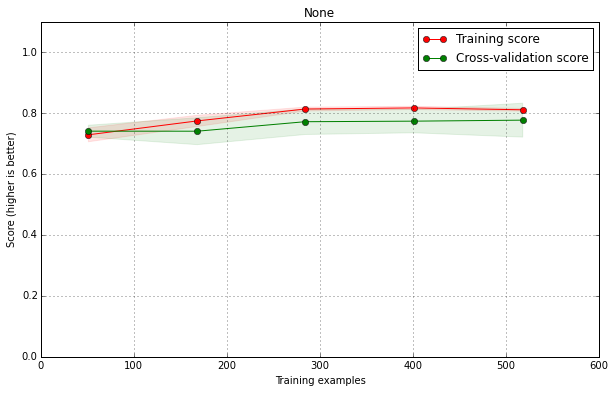

CPU times: user 868 ms, sys: 248 ms, total: 1.12 s
Wall time: 12.2 s


In [7]:
%%time

try:
    from sklearn_utilities import plot_learning_curve
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_learning_curve

plot_learning_curve(estimator   = clf, 
                    title       = None, 
                    X           = X_train, 
                    y           = y_train, 
                    ylim        = (0.0, 1.10), 
                    cv          = StratifiedKFold(y            = y_train, 
                                                  n_folds      = 10, 
                                                  shuffle      = True, 
                                                  random_state = SEED), 
                    train_sizes = np.linspace(.1, 1.0, 5),
                    n_jobs      = 1)

plt.show()

# Training set predictions

In [8]:
%%time

train_preds = cross_val_predict(estimator    = clf, 
                                X            = X_train, 
                                y            = y_train, 
                                cv           = StatifiedCV, 
                                n_jobs       = -1, 
                                verbose      = 0, 
                                fit_params   = None, 
                                pre_dispatch = '2*n_jobs')

y_true, y_pred   = y_train, train_preds

CPU times: user 56 ms, sys: 24 ms, total: 80 ms
Wall time: 377 ms


[[404  34]
 [ 94  44]]


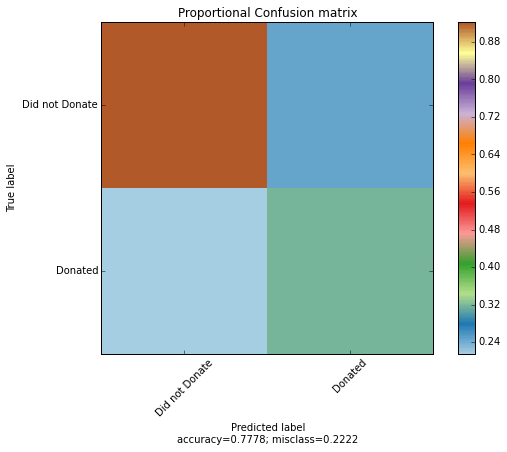

Accuracy 0.7778, mis-class rate 0.2222


In [9]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=None)
print cm

try:
    from sklearn_utilities import plot_confusion_matrix
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_confusion_matrix


plot_confusion_matrix(cm, ['Did not Donate','Donated'])

accuracy = round(np.trace(cm)/float(np.sum(cm)),4)
misclass = 1 - accuracy
print("Accuracy {}, mis-class rate {}".format(accuracy,misclass))

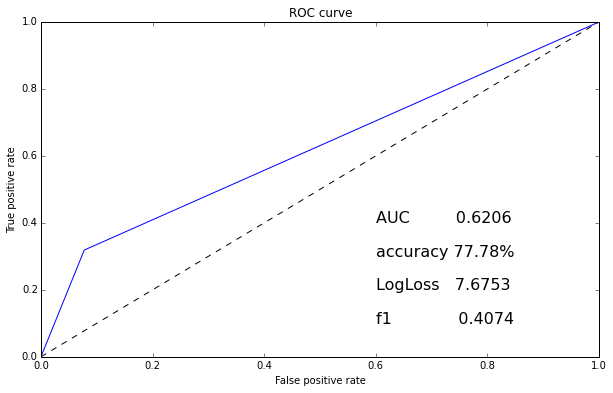

In [10]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score

fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=None)


plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)

AUC = roc_auc_score(y_true, y_pred, average='macro')
plt.text(x=0.6,y=0.4,s="AUC         {:.4f}"\
         .format(AUC),
        fontsize=16)

plt.text(x=0.6,y=0.3,s="accuracy {:.2f}%"\
         .format(accuracy*100),
        fontsize=16)

logloss = log_loss(y_true, y_pred)
plt.text(x=0.6,y=0.2,s="LogLoss   {:.4f}"\
         .format(logloss),
        fontsize=16)

f1 = f1_score(y_true, y_pred)
plt.text(x=0.6,y=0.1,s="f1             {:.4f}"\
         .format(f1),
        fontsize=16)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

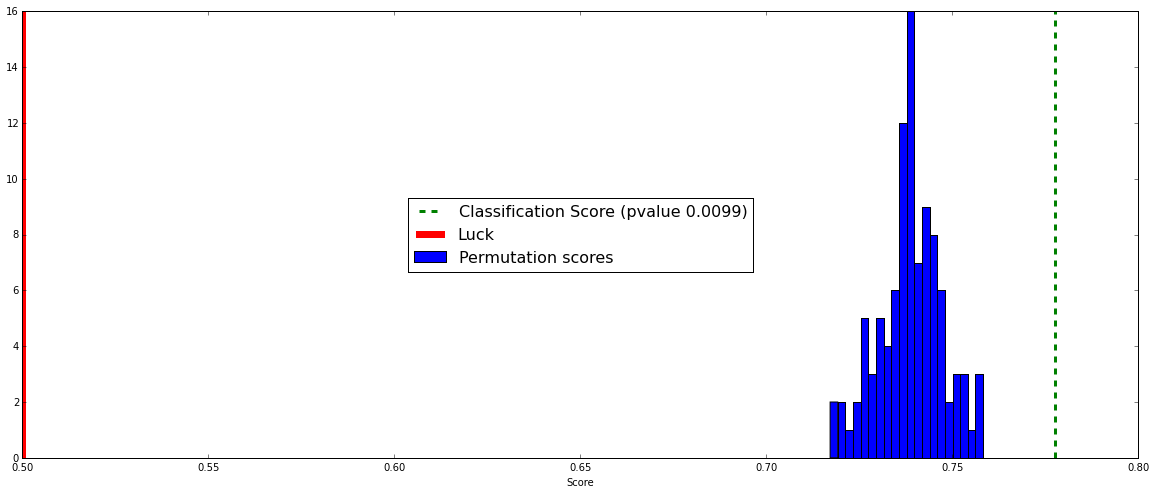

CPU times: user 384 ms, sys: 92 ms, total: 476 ms
Wall time: 16.9 s


In [11]:
%%time

score, permutation_scores, pvalue = permutation_test_score(estimator      = clf, 
                                                           X              = X_train.values.astype(np.float32), 
                                                           y              = y_train, 
                                                           cv             = StatifiedCV, 
                                                           labels         = None,
                                                           random_state   = SEED,
                                                           verbose        = 0,
                                                           n_permutations = 100, 
                                                           scoring        = None,
                                                           n_jobs         = -1) 

plt.figure(figsize=(20,8))
plt.hist(permutation_scores, 20, label='Permutation scores')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score (pvalue {:.4f})'.format(pvalue))
         
plt.plot(2 * [1. / N_CLASSES], ylim, 'r', linewidth=7, label='Luck')

plt.ylim(ylim)
plt.legend(loc='center',fontsize=16)
plt.xlabel('Score')
plt.show()

# find mean and stdev of the scores
from scipy.stats import norm
mu, std = norm.fit(permutation_scores)

In [12]:
# format for scores.csv file
import re
algo = re.search(r"submission_(.*?)\.csv", submission_filename).group(1)
print("{: <26} ,        ,   {:.4f} ,  {:.4f} , {:.4f} , {:.4f} , {:.4f} , {:.4f}"\
      .format(algo,accuracy,logloss,AUC,f1,mu,std))

KNeighborsClassifier       ,        ,   0.7778 ,  7.6753 , 0.6206 , 0.4074 , 0.7387 , 0.0086


# --------------------------------------------------------------------------------------------

# Test Set Predictions

## Re-fit with the full training set

In [13]:
clf.set_params(**clf_params)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='chebyshev',
           metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
           weights='uniform')

## Read the test data

In [14]:
from load_blood_data import load_blood_data

X_test, IDs = load_blood_data(train=False, SEED   = SEED, 
                                           scale  = scale,
                                           minmax = minmax,
                                           norm   = norm,
                                           nointercept = nointercept,
                                           engineering = engineering)

# Predict the test set with the fitted model

In [15]:
y_pred = clf.predict(X_test)
print(y_pred[:10])

try:
    y_pred_probs  = clf.predict_proba(X_test)
    print(y_pred_probs[:10])
    donate_probs  = [prob[1] for prob in y_pred_probs]
except Exception,e:
    print(e)
    donate_probs = [0.65 if x>0 else 1-0.65 for x in y_pred]
    
print(donate_probs[:10])

[0 0 0 0 0 1 0 0 0 0]
[[ 0.66666667  0.33333333]
 [ 0.88888889  0.11111111]
 [ 0.77777778  0.22222222]
 [ 0.88888889  0.11111111]
 [ 0.66666667  0.33333333]
 [ 0.44444444  0.55555556]
 [ 0.66666667  0.33333333]
 [ 1.          0.        ]
 [ 0.88888889  0.11111111]
 [ 1.          0.        ]]
[0.33333333333333331, 0.1111111111111111, 0.22222222222222221, 0.1111111111111111, 0.33333333333333331, 0.55555555555555558, 0.33333333333333331, 0.0, 0.1111111111111111, 0.0]


# Create the submission file

In [44]:
assert len(IDs)==len(donate_probs)

f = open(submission_filename, "w")

f.write(",Made Donation in March 2007\n")
for ID, prob in zip(IDs, donate_probs):
    f.write("{},{}\n".format(ID,prob))
    
f.close()